#Прогнозирование акций Лукойл

In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from keras.optimizers import Adam #Оптимизатор
from keras.models import Sequential, Model #Два варианты моделей
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, CuDNNLSTM #Стандартные слои
from google.colab import files #Загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики

# Рисовать графики сразу же
%matplotlib inline

Using TensorFlow backend.


In [ ]:
#Загружаем файл базы
files.upload()
!ls

Saving 16_17.csv to 16_17.csv
Saving 18_19.csv to 18_19.csv
16_17.csv  18_19.csv  sample_data


In [ ]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('18_19.csv')

In [ ]:
#Выцепялем numpy значения .values
#И выводим нулевой
txt = base_data.values[0]
print(txt)

['03.01.2018;10:00:00;3341;3356;3340;3355;6088']


In [ ]:
#Преобразование строк с числами в лист float
def strList2Float(lst):
  return [float(i) for i in lst]

#Загружаем выборку
def getData(df):
  values = df.values #Вытаскиваем значение из data frame
  data = [] #Создаём пустую базу
  
  #Проходим по всем строкам данных
  for v in values:
    currStr = v[0].split(sep=";") #Разбиваем на значения, раделитель - ;
    currStr = currStr[2:] #Отбрасываем два первых значения - в них даты
    currStr = strList2Float(currStr) #Превращаем оставшиеся значения из листа строк в лист float
    data.append(currStr) #Добавляем элемент в базу
  
  return data

#Получаем данные из файла
def getDataFromFile(fileName):
  df = pd.read_csv(fileName) #Считываем файл с помощью pandas
  return getData(df) #Возвращаем считанные данные из файла

In [ ]:
#Считываем данные из двух файлов
#16-17 год и 18-19 год
data16_17 = getDataFromFile('16_17.csv')
data18_19 = getDataFromFile('18_19.csv')

In [ ]:
#Объединяем базы из двух файлов
data = data16_17.copy() #Создаем копию первой базы
data.extend(data18_19) #Присоединяем в ней втору базу
data = np.array(data) #Превращаем в numpy массив

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


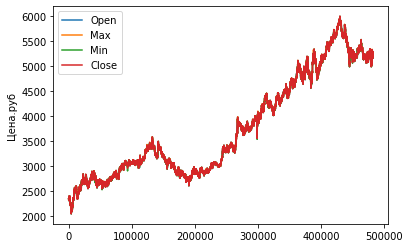

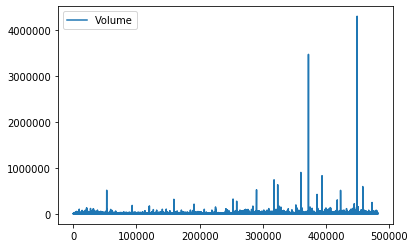

In [ ]:
#Отображаем исходные от точки start и длинной step
start = 0 #С какой точки начинаем
step = data.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#Четыре основных канала - open, max, min, close
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+step,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volomu
plt.plot(data[start:start+step,4], label="Volume")
plt.legend()
plt.show()

**Функция загрузки данных**

In [ ]:
#Функция "раскусывания" данных для временных рядов
#data - данные
#xLen - размер фрема, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будутее
#если 0 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#returnFlatten - делать ли одномерный вектор на выходе для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производную
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):
  
  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (xNormalization == 0):
    xScaler = StandardScaler()
  else:
    xScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  xData = data[:,xChannels]
  #Обучаем нормировщик
  xScaler.fit(xData)
  #Нормируем данные
  xData = xScaler.transform(xData)

  #Выбираем тип нормализации y
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (yNormalization == 0):
    yScaler = StandardScaler()
  else:
    yScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  yData = data[:,yChannels]
  #Обучаем нормировщик
  yScaler.fit(yData)
  #Нормируем данные
  yData = yScaler.transform(yData)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i+xLen, xChannels] for i in range(xData.shape[0]-xLen-1-stepsForward)])
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 0):
    yTrain = np.array([yData[i+xLen:i+xLen+stepsForward, yChannels] for i in range(yData.shape[0]-xLen-1-stepsForward)])
  else:
    yTrain = np.array([yData[i+xLen+stepsForward, yChannels] for i in range(yData.shape[0]-xLen-1-stepsForward)])

  #Делаем reshape y в зависимости от того
  #Прогнозируем на 1 шаг вперёдили на несколько
  if (stepsForward == 0):
    if ((len(yChannels) == 1)):
      yTrain = yTrain.reshape(yTrain.shape[0], 1)
  else:
      yTrain = yTrain.reshape(yTrain.shape[0], stepsForward)
  
  #Расчитыываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

###Вариант 1

In [ ]:
#Формируем параметры загрузки данных
xLen = 300 #Анализируем по 300 прошедшим точкам 
stepsForward = 0 #Предсказываем на 1 шаг вперёд
xChannels = range(data.shape[1]) #Используем все входные каналы
yChannels = [0] #Предказываем только open канал
xNormalization = 0 #Нормируем входные каналы стандартным распределением
yNormalization = 0#Нормируем выходные каналы стандартным распределением
valLen = 30000 #Используем 30.000 записей для проверки0
returnFlatten = 1 #Вернуть одномерные векторы
convertToDerivative = 0 #Не превращать в производную

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(451269, 1500)
(451269, 1)
(30000, 1500)
(30000, 1)


##Полносвязная сеть

Train on 451269 samples, validate on 30000 samples
Epoch 1/20



451269/451269 [==============================] - 78s 172us/step - loss: 0.1013 - val_loss: 0.0187
Epoch 2/20
451269/451269 [==============================] - 73s 162us/step - loss: 0.0590 - val_loss: 0.0140
Epoch 3/20
451269/451269 [==============================] - 74s 165us/step - loss: 0.0376 - val_loss: 0.0265
Epoch 4/20
451269/451269 [==============================] - 73s 163us/step - loss: 0.0234 - val_loss: 0.0068
Epoch 5/20
451269/451269 [==============================] - 73s 161us/step - loss: 0.0155 - val_loss: 0.0047
Epoch 6/20
451269/451269 [==============================] - 74s 164us/step - loss: 0.0086 - val_loss: 0.0018
Epoch 7/20
451269/451269 [==============================] - 75s 166us/step - loss: 0.0052 - val_loss: 9.6410e-04
Epoch 8/20
451269/451269 [==============================] - 74s 165us/step - loss: 0.0025 - val_loss: 4.1001e-04
Epoch 9/20
451269/451269 [==============================] - 74s 164us/step - loss: 0.0012 - val_loss: 2.2165e-04
Epoch 10/20
451269

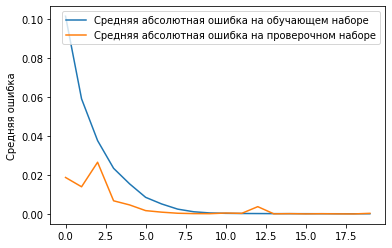

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(100, input_dim = xTrain.shape[1], activation="linear"))
modelD.add(Dense(yTrain.shape[1], activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=20, 
                    verbose=1, 
                    validation_data=(xVal, yVal))

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

#Визуализация результатов

In [ ]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
#Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  #РАссчитываем основные показатели
  ma = a.mean() #Среднее значение первого вектора
  mb = b.mean() #Среднее значение второго вектора
  mab = (a*b).mean() #Среднее значение произведения векторов
  sa = a.std() #Среднеквадратичное отклонение первого вектора
  sb = b.std() #Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисуем корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    #Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      #Получаем сигнал, смещённый на i шагов назад
      #predVal[i:, ch]
      #Сравниваем его с верными ответами, без смещения назад
      #yValUnscaled[:yLen-i,ch]
      #Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    #Отображаем график коррелций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler) #Прогнозируем данные

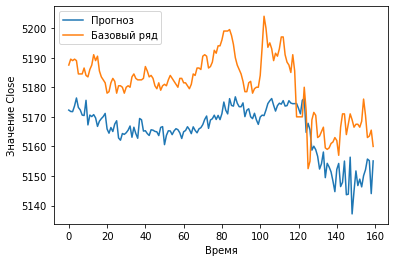

In [ ]:
#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

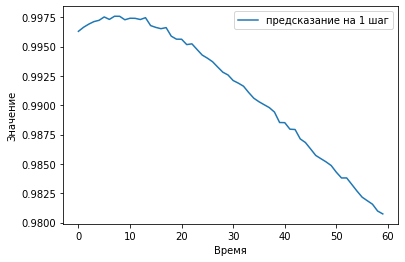

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

##Одномерная свёртка


In [ ]:
#Формируем параметры загрузки данных
xLen = 300
stepsForward = 0
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 30000
returnFlatten = 0 #Возвращаем двумерные данные для свёртки
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(451269, 300, 5)
(451269, 1)
(30000, 300, 5)
(30000, 1)









Train on 451269 samples, validate on 30000 samples
Epoch 1/20





451269/451269 [==============================] - 108s 239us/step - loss: 0.2304 - val_loss: 0.0200
Epoch 2/20
451269/451269 [==============================] - 102s 227us/step - loss: 0.0124 - val_loss: 6.4314e-04
Epoch 3/20
451269/451269 [==============================] - 101s 223us/step - loss: 2.3661e-04 - val_loss: 1.0543e-04
Epoch 4/20
451269/451269 [==============================] - 101s 223us/step - loss: 1.4790e-04 - val_loss: 1.0455e-04
Epoch 5/20
451269/451269 [==============================] - 101s 224us/step - loss: 1.0243e-04 - val_loss: 6.5432e-05
Epoch 6/20
451269/451269 [==============================] - 101s 223us/step - loss: 9.6966e-05 - val_loss: 2.2102e-05
Epoch 7/20
451269/451269 [==============================] - 103s 228us/step - loss: 8.2093e-05 - val_loss: 5.1263e-05
Epoch 8/20
451269/451269 [==============================] - 104s 232us/step - loss: 7.3010e-05 - val_loss: 6.7297e-05
Epoch

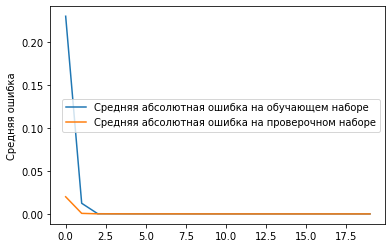

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(50, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(10, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit(xTrain, 
                    yTrain, 
                    epochs=20, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

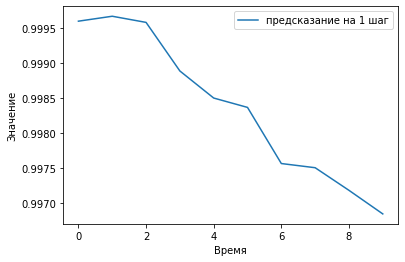

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

###Вариант 2

In [ ]:
#Формируем параметры загрузки данных
xLen = 300
stepsForward = 10
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 30000
returnFlatten = 1 
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)


(451249, 1500)
(451249, 10)
(30000, 1500)
(30000, 10)


Train on 451249 samples, validate on 30000 samples
Epoch 1/20
451249/451249 [==============================] - 75s 167us/step - loss: 0.0600 - val_loss: 0.0045
Epoch 2/20
451249/451249 [==============================] - 75s 166us/step - loss: 0.0108 - val_loss: 0.0035
Epoch 3/20
451249/451249 [==============================] - 75s 166us/step - loss: 0.0091 - val_loss: 0.0073
Epoch 4/20
451249/451249 [==============================] - 76s 167us/step - loss: 0.0080 - val_loss: 0.0022
Epoch 5/20
451249/451249 [==============================] - 75s 166us/step - loss: 0.0069 - val_loss: 0.0020
Epoch 6/20
451249/451249 [==============================] - 74s 164us/step - loss: 0.0060 - val_loss: 0.0063
Epoch 7/20
451249/451249 [==============================] - 74s 165us/step - loss: 0.0055 - val_loss: 0.0030
Epoch 8/20
451249/451249 [==============================] - 75s 165us/step - loss: 0.0045 - val_loss: 0.0017
Epoch 9/20
451249/451249 [==============================] - 75s 165us/step - 

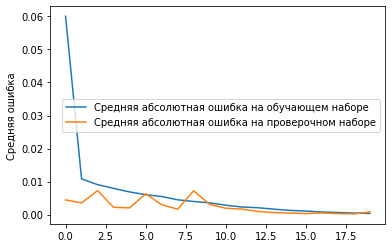

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(100, input_dim = xTrain.shape[1], activation="linear"))
modelD.add(Dense(yTrain.shape[1], activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=20, 
                    verbose=1, 
                    validation_data=(xVal, yVal))

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Функция рассчитываем результаты прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
#Функция расёта корреляции двух одномерных векторов
def correlate(a, b):
  #РАссчитываем основные показатели
  ma = a.mean() #Среднее значение первого вектора
  mb = b.mean() #Среднее значение второго вектора
  mab = (a*b).mean() #Среднее значение произведения векторов
  sa = a.std() #Среднеквадратичное отклонение первого вектора
  sb = b.std() #Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисуем корреляцию прогнозированного сигнала с правильным

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    #Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))
      plt.plot(corr, label='предсказание на ' + str(ch+i) + ' шаг')
      plt.xlabel('Время')
      plt.ylabel('Значение')
      plt.legend()
      plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

##LSTM

In [ ]:
#Функция "раскусывания" данных для временных рядов

def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):

  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  
  #Выбираем тип нормализации x
  
  if (xNormalization == 0):
    xScaler = StandardScaler()
  else:
    xScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  xData = data[:,xChannels]
  #Обучаем нормировщик
  xScaler.fit(xData)
  #Нормируем данные
  xData = xScaler.transform(xData)

  #Выбираем тип нормализации y
  
  if (yNormalization == 0):
    yScaler = StandardScaler()
  else:
    yScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  yData = data[:,yChannels]
  #Обучаем нормировщик
  yScaler.fit(yData)
  #Нормируем данные
  yData = yScaler.transform(yData)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i+xLen, xChannels] for i in range(xData.shape[0]-xLen-1-stepsForward)])
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 0):
    yTrain = np.array([yData[i+xLen:i+xLen+stepsForward, yChannels] for i in range(yData.shape[0]-xLen-1-stepsForward)])
  else:
    yTrain = np.array([yData[i+xLen+stepsForward, yChannels] for i in range(yData.shape[0]-xLen-1-stepsForward)])

  #Делаем reshape y в зависимости от того
  #Прогнозируем на 1 шаг вперёдили на несколько
  if (stepsForward == 0):
    if ((len(yChannels) == 1)):
      yTrain = yTrain.reshape(yTrain.shape[0], 1)
  else:
      yTrain = yTrain.reshape(yTrain.shape[0], stepsForward)
  
  #Расчитыываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [ ]:
#Формируем параметры загрузки данных
xLen = 300
stepsForward = 10
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 30000
returnFlatten = 0 #Возвращаем двумерные данные для свёртки
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(451249, 300, 5)
(451249, 10)
(30000, 300, 5)
(30000, 10)








Train on 45125 samples, validate on 30000 samples
Epoch 1/10





45125/45125 [==============================] - 40s 897us/step - loss: 1.0286 - val_loss: 2.2536
Epoch 2/10
45125/45125 [==============================] - 34s 745us/step - loss: 0.8816 - val_loss: 1.8484
Epoch 3/10
45125/45125 [==============================] - 34s 745us/step - loss: 0.7356 - val_loss: 1.4769
Epoch 4/10
45125/45125 [==============================] - 34s 747us/step - loss: 0.5582 - val_loss: 1.0241
Epoch 5/10
45125/45125 [==============================] - 33s 740us/step - loss: 0.3768 - val_loss: 0.6544
Epoch 6/10
45125/45125 [==============================] - 34s 746us/step - loss: 0.2398 - val_loss: 0.3844
Epoch 7/10
45125/45125 [==============================] - 34s 746us/step - loss: 0.1480 - val_loss: 0.2023
Epoch 8/10
45125/45125 [==============================] - 33s 741us/step - loss: 0.0877 - val_loss: 0.0927
Epoch 9/10
45125/45125 [==============================] - 34s 745us/step - loss: 0.

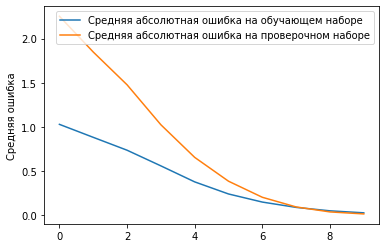

In [ ]:
modelL = Sequential()
modelL.add(CuDNNLSTM(5, input_shape = (xTrain.shape[1], xTrain.shape[2])))
modelL.add(Dense(10, activation="linear"))
modelL.add(Dense(yTrain.shape[1], activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelL.fit(xTrain[::10,:], 
                    yTrain[::10,:], 
                    epochs=10, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Функция рассчитываем результаты прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
#Функция расёта корреляции двух одномерных векторов
def correlate(a, b):
  #РАссчитываем основные показатели
  ma = a.mean() #Среднее значение первого вектора
  mb = b.mean() #Среднее значение второго вектора
  mab = (a*b).mean() #Среднее значение произведения векторов
  sa = a.std() #Среднеквадратичное отклонение первого вектора
  sb = b.std() #Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисуем корреляцию прогнозированного сигнала с правильным

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    #Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))
      plt.plot(corr, label='предсказание на ' + str(ch+i) + ' шаг')
      plt.xlabel('Время')
      plt.ylabel('Значение')
      plt.legend()
      plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelL
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

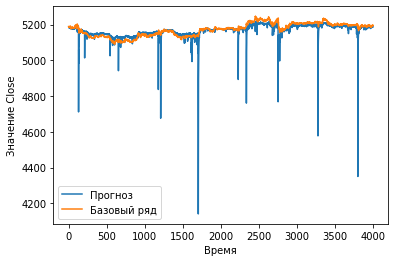

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

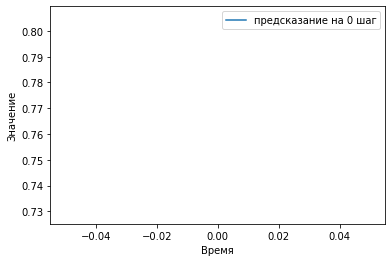

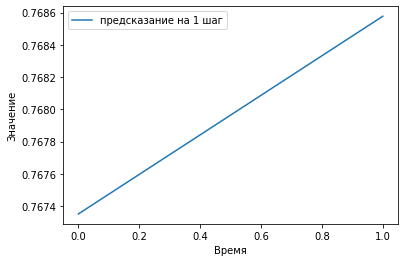

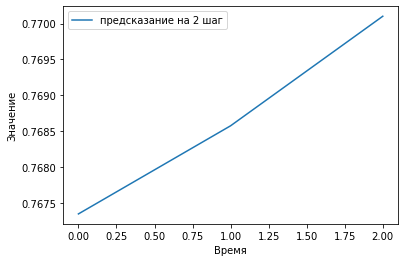

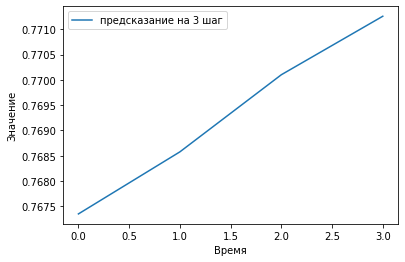

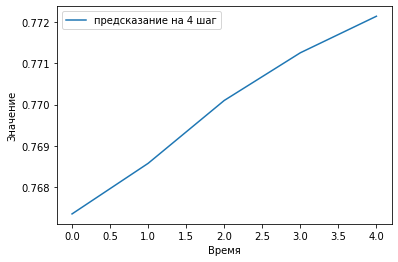

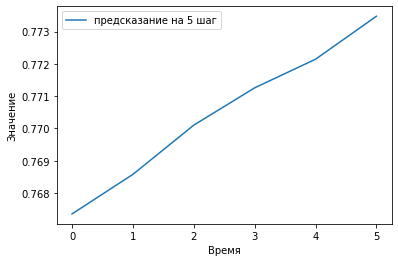

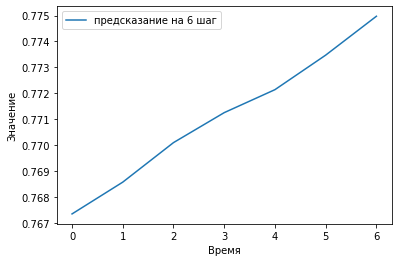

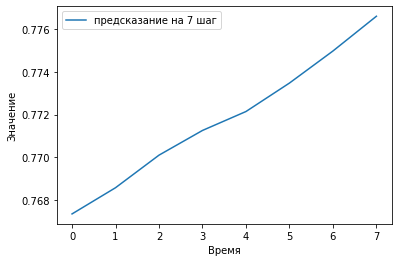

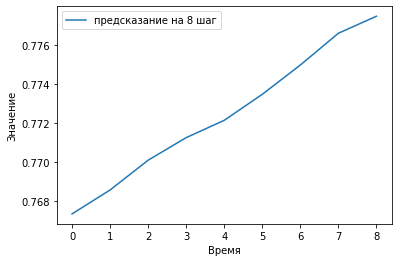

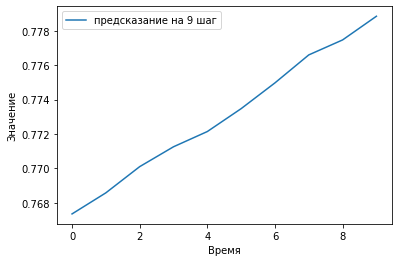

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## Вариант3

In [ ]:
#Формируем параметры загрузки данных
xLen = 300
stepsForward = 0
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 30000
returnFlatten = 0 #Возвращаем двумерные данные для свёртки
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(451269, 300, 5)
(451269, 1)
(30000, 300, 5)
(30000, 1)


Train on 451269 samples, validate on 30000 samples
Epoch 1/20
451269/451269 [==============================] - 69s 153us/step - loss: 0.3355 - val_loss: 0.0275
Epoch 2/20
451269/451269 [==============================] - 68s 151us/step - loss: 0.0198 - val_loss: 6.0182e-04
Epoch 3/20
451269/451269 [==============================] - 68s 151us/step - loss: 3.9874e-04 - val_loss: 2.2518e-04
Epoch 4/20
451269/451269 [==============================] - 69s 152us/step - loss: 2.0513e-04 - val_loss: 6.1854e-05
Epoch 5/20
451269/451269 [==============================] - 69s 153us/step - loss: 1.6333e-04 - val_loss: 6.2328e-05
Epoch 6/20
451269/451269 [==============================] - 68s 151us/step - loss: 1.0685e-04 - val_loss: 1.6391e-04
Epoch 7/20
451269/451269 [==============================] - 68s 150us/step - loss: 1.0758e-04 - val_loss: 1.6240e-04
Epoch 8/20
451269/451269 [==============================] - 68s 151us/step - loss: 7.7772e-05 - val_loss: 5.1299e-05
Epoch 9/20
451269/451269 

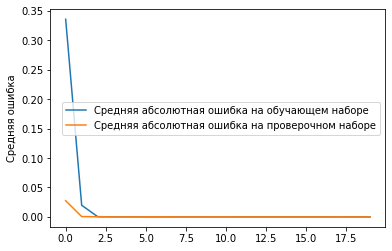

In [ ]:
modelP = Sequential()

modelP.add(Conv1D(50, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
modelP.add(Flatten())
modelP.add(Dense(10, activation="linear"))
modelP.add(Dense(yTrain.shape[1], activation="linear"))

modelP.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelP.fit(xTrain, 
                    yTrain, 
                    epochs=20, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Функция рассчитываем результаты прогнозирования сети


def getPred(currModel, xVal, yVal, yScaler):
  
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
#Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  
  ma = a.mean() #Среднее значение первого вектора
  mb = b.mean() #Среднее значение второго вектора
  mab = (a*b).mean() #Среднее значение произведения векторов
  sa = a.std() #Среднеквадратичное отклонение первого вектора
  sb = b.std() #Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисуем корреляцию прогнозированного сигнала с правильным

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  
  for ch in channels:
    corr = [] 
    yLen = yValUnscaled.shape[0] 

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelP
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

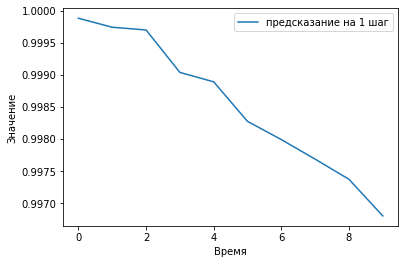

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)